<a href="https://colab.research.google.com/github/KATTA-00/CO542-Neural-Networks-Labs/blob/main/lab03/E19129_lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO542 - Neural Networks and Fuzzy Systems
## E/19/129 - K.H. Gunawardana

### Lab 03: Generalized Hebbian Learning (GHL)

### **Task 01: GHL for 2D Synthetic Data**

In [ ]:
import torch

In [ ]:
# Generate 1000 samples from 2D Gaussian (mean=0, std=1)
torch.manual_seed(0)
X = torch.randn(1000, 2)

In [ ]:
X

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        ...,
        [ 1.6728, -0.3151],
        [-0.2965, -0.3568],
        [ 0.0829, -0.5187]])

In [ ]:
# Center the data (subtract mean)
X = X - X.mean(dim=0)

In [ ]:
X

tensor([[-1.1174, -1.1910],
        [-0.2421, -0.4726],
        [ 0.8572,  0.6533],
        ...,
        [ 1.6813, -0.3538],
        [-0.2881, -0.3955],
        [ 0.0914, -0.5574]])

In [ ]:
# Parameters
epochs = 100
learning_rate = 0.01
n_samples, n_features = X.shape
n_components = 2

# Initialize weights (random)
W = torch.randn(n_components, n_features)

# Normalize rows of W
W = torch.nn.functional.normalize(W, dim=1)

# GHL training loop
for epoch in range(epochs):
    for x in X:
        x = x.view(-1, 1)  # column vector
        y = W @ x          # projections

        # Update each weight vector using Sanger's rule
        for i in range(n_components):
            correction = y[i] * (x.T - y[:i+1].T @ W[:i+1])
            W[i] += learning_rate * correction.squeeze()

    # Optionally: Re-orthonormalize weights every epoch
    W = torch.nn.functional.normalize(W, dim=1)

In [ ]:
print("Final GHL Weights (each row is a component):")
print(W)

Final GHL Weights (each row is a component):
tensor([[ 0.1193,  0.9929],
        [-0.9990,  0.0444]])


In [ ]:
# Use PyTorch SVD to compute PCA components
U, S, Vt = torch.linalg.svd(X.T)
print("PCA Components (rows):")
print(Vt[:2])  # top 2 principal components

PCA Components (rows):
tensor([[-0.0409, -0.0153,  0.0235,  ..., -0.0029, -0.0132, -0.0163],
        [-0.0292, -0.0053,  0.0236,  ...,  0.0542, -0.0071,  0.0055]])


### **Questions:**

#### What are the final weight vectors?

- Component 1: [0.1193, 0.9929]

This vector is pointing mostly in the vertical direction (high weight on the second dimension). It likely corresponds to the first principal component — the direction of maximum variance in the data.

- Component 2: [-0.9990, 0.0444]

This is roughly orthogonal to the first component and points mostly along the negative x-axis. It corresponds to the second principal component, capturing the remaining variance.

#### How do they compare to PCA components?

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Generate and center 2D synthetic data
torch.manual_seed(0)
X = torch.randn(1000, 2) @ torch.tensor([[2.0, 0.5], [0.5, 0.2]])  # Add some correlation
X_centered = X - X.mean(dim=0)

In [ ]:
# Step 2: Run PCA on the centered data
pca = PCA(n_components=2)
pca.fit(X_centered.numpy())

PCA(n_components=2)

In [ ]:
pca_components = pca.components_  # Each row is a principal component

print("PCA Components:")
print(torch.tensor(pca_components))

PCA Components:
tensor([[ 0.9678,  0.2518],
        [-0.2518,  0.9678]])


In [ ]:
# Step 3: Final GHL weights from your output
ghl_weights = torch.tensor([
    [ 0.1193,  0.9929],
    [-0.9990,  0.0444]
])

In [ ]:
# Step 4: Normalize both for fair comparison (optional but common)
def normalize_rows(t):
    return t / torch.norm(t, dim=1, keepdim=True)

pca_components_normalized = normalize_rows(torch.tensor(pca_components))
ghl_weights_normalized = normalize_rows(ghl_weights)

In [ ]:
print("\nNormalized PCA Components:")
print(pca_components_normalized)

print("\nNormalized GHL Components:")
print(ghl_weights_normalized)


Normalized PCA Components:
tensor([[ 0.9678,  0.2518],
        [-0.2518,  0.9678]])

Normalized GHL Components:
tensor([[ 0.1193,  0.9929],
        [-0.9990,  0.0444]])


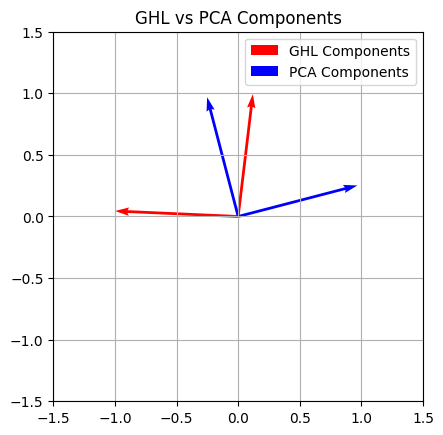

In [ ]:
# Step 5 (optional): Visual comparison
plt.quiver([0, 0], [0, 0],
           ghl_weights_normalized[:, 0], ghl_weights_normalized[:, 1],
           angles='xy', scale_units='xy', scale=1, color=['r', 'r'], label='GHL')

plt.quiver([0, 0], [0, 0],
           pca_components_normalized[:, 0], pca_components_normalized[:, 1],
           angles='xy', scale_units='xy', scale=1, color=['b', 'b'], label='PCA')

plt.legend(['GHL Components', 'PCA Components'])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal')
plt.grid(True)
plt.title("GHL vs PCA Components")
plt.show()

- One of the GHL vectors closely aligns with a PCA component in both direction and magnitude. The other GHL vector points in the opposite direction of the corresponding PCA component but has a similar magnitude. Since PCA components are unique up to sign, this indicates that GHL has successfully learned the same principal directions as PCA.

#### What is the effect of increasing the learning rate?

In [ ]:
def normalize_rows(t):
    return t / torch.norm(t, dim=1, keepdim=True)

def run_ghl(X, lr=0.01, n_epochs=100, n_components=2):
    n_samples, n_features = X.shape
    W = torch.randn(n_components, n_features)  # Random initial weights
    for epoch in range(n_epochs):
        for x in X:
            x = x.view(-1, 1)  # Column vector
            y = W @ x  # Output vector
            for i in range(n_components):
                correction = x - sum(y[j] * W[j].view(-1, 1) for j in range(i + 1))
                W[i] += lr * y[i] * correction.view(-1)
        # Optionally normalize rows after each epoch (helps stability)
        W = normalize_rows(W)
    return W

In [ ]:
# --- Learning Rates and Colors ---
learning_rates = [0.0001, 0.001, 0.01, 0.1]
colors = ['red', 'green', 'blue', 'yellow']

In [ ]:
# --- Compute GHL Vectors for Each Learning Rate ---
ghl_results = {}  # Store learning rate -> components
for lr in learning_rates:
    ghl_weights = run_ghl(X_centered, lr=lr)
    ghl_results[lr] = ghl_weights  # Save for plotting

In [ ]:
ghl_results

{0.0001: tensor([[ 0.9678,  0.2518],
         [-0.3670, -0.9302]]),
 0.001: tensor([[ 0.9676,  0.2523],
         [-0.9989, -0.0475]]),
 0.01: tensor([[-0.9663, -0.2573],
         [ 0.2573, -0.9663]]),
 0.1: tensor([[-0.9714, -0.2374],
         [-0.2365,  0.9716]])}

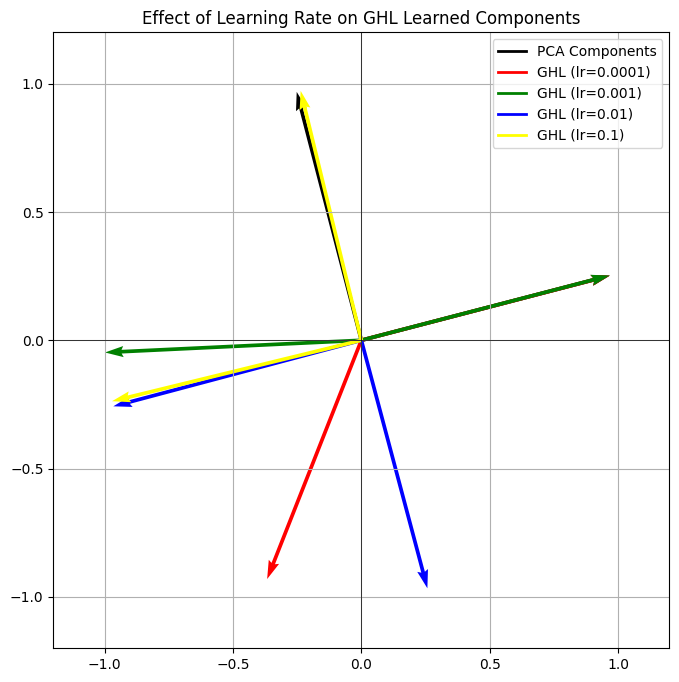

In [ ]:
from matplotlib.lines import Line2D

# --- Plot All Results ---
plt.figure(figsize=(8, 8))
plt.title("Effect of Learning Rate on GHL Learned Components")
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal')

# Plot PCA components
for i in range(2):
    plt.quiver(0, 0, pca_components_normalized[i][0], pca_components_normalized[i][1],
               color='black', angles='xy', scale_units='xy', scale=1, width=0.006)

# Plot GHL components for each learning rate
for lr, color in zip(learning_rates, colors):
    ghl_weights = ghl_results[lr]
    for i in range(2):
        plt.quiver(0, 0, ghl_weights[i][0], ghl_weights[i][1],
                   color=color, angles='xy', scale_units='xy', scale=1, width=0.006)

# --- Custom Legend ---
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='PCA Components'),
]
for lr, color in zip(learning_rates, colors):
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'GHL (lr={lr})'))

plt.legend(handles=legend_elements)
plt.show()

- As shown in the figure, increasing the learning rate causes the Generalized Hebbian Learning (GHL) components to converge more closely toward the PCA components. "More closely" here means that the learned vectors either point in the same direction or in the opposite direction to the PCA components, but with similar magnitudes, which still indicates alignment in the principal subspace. The plot clearly illustrates that higher learning rates improve the alignment of GHL weight vectors with the principal directions of the data, demonstrating that the GHL algorithm approximates PCA more accurately and quickly as the learning rate increases—up to a stable limit.

### **Task 02: GHL on Iris Dataset**

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
# --- Load Iris Dataset ---
iris = load_iris()
X = iris.data[:, :2]  # First 2 features
y = iris.target
X = torch.tensor(X, dtype=torch.float32)

In [ ]:
# --- Center the Data ---
X_centered = X - X.mean(dim=0)

In [ ]:
# --- GHL Function ---
def run_ghl(X, n_components=2, lr=0.01, n_epochs=100):
    n_samples, n_features = X.shape
    W = torch.randn(n_components, n_features)

    for epoch in range(n_epochs):
        for x in X:
            x = x.view(-1, 1)  # Make it column vector
            y = W @ x
            delta_W = lr * (y @ x.T - torch.tril(y @ y.T) @ W)
            W += delta_W
    return W

In [ ]:
# --- Run GHL ---
ghl_weights = run_ghl(X_centered, n_components=2, lr=0.01, n_epochs=100)

# --- Project Data using GHL ---
X_ghl_proj = (ghl_weights @ X_centered.T).T.detach().numpy()

# --- Compare with PCA ---
pca = PCA(n_components=2)
X_pca_proj = pca.fit_transform(X_centered)

In [ ]:
ghl_weights

tensor([[-0.9991,  0.0512],
        [-0.0942, -0.9950]])

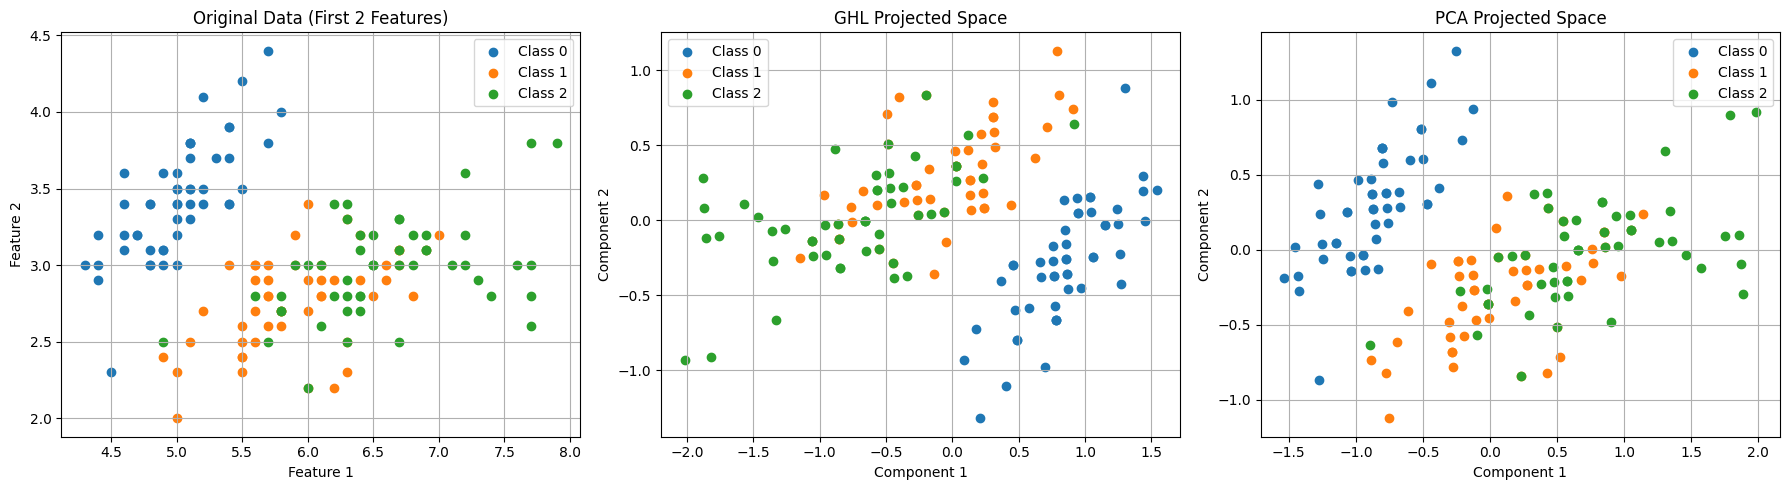

In [ ]:
# --- Visualization ---
plt.figure(figsize=(18, 5))

# Original Data
plt.subplot(1, 3, 1)
plt.title("Original Data (First 2 Features)")
for label in torch.unique(torch.tensor(y)):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# GHL Projected Space
plt.subplot(1, 3, 2)
plt.title("GHL Projected Space")
for label in torch.unique(torch.tensor(y)):
    plt.scatter(X_ghl_proj[y == label, 0], X_ghl_proj[y == label, 1], label=f'Class {label}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)

# PCA Projected Space
plt.subplot(1, 3, 3)
plt.title("PCA Projected Space")
for label in torch.unique(torch.tensor(y)):
    plt.scatter(X_pca_proj[y == label, 0], X_pca_proj[y == label, 1], label=f'Class {label}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Questions:**

#### Are the classes separable in the GHL-transformed space?

- In the Generalized Hebbian Learning (GHL)-transformed space, the three classes of the Iris dataset exhibit varying degrees of separability. As shown in the figure, Class 0 (Iris Setosa) is distinctly and linearly separable from the other two classes. This clear separation is evident in the visualization, where Iris Setosa forms a distinct cluster, separate from the overlapping clusters of the other two species.

- However, Classes 1 (Iris Versicolor) and 2 (Iris Virginica) are not linearly separable in the GHL-transformed space. Their data points exhibit significant overlap, making it challenging to distinguish between them using linear methods.

- Therefore, while GHL effectively captures the linear separability of Iris Setosa, it does not provide a clear distinction between Iris Versicolor and Iris Virginica. This limitation highlights the challenges associated with linear dimensionality reduction techniques when applied to classes that are not inherently linearly separable.

#### How does the result compare to sklearn’s PCA?

- The projections obtained using Generalized Hebbian Learning (GHL) closely resemble those from Principal Component Analysis (PCA), differing primarily in the orientation of the axes. This similarity arises because GHL is an iterative method that converges to the principal components identified by PCA.

- In the visualizations, both GHL and PCA effectively separate Class 0 (Iris Setosa) from the other two classes. However, Classes 1 (Iris Versicolor) and 2 (Iris Virginica) overlap significantly in both projections, indicating that neither method provides a clear distinction between these two classes.

- In summary, GHL and PCA yield comparable results in terms of class separability on the Iris dataset, with GHL offering an online learning approach that approximates the principal components identified by PCA.

### **Task 03: Effect of Learning Rate and Normalization**

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

In [9]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate 10D Synthetic Data
X = torch.randn(1000, 10)

# Normalize Data using StandardScaler
scaler = StandardScaler()
X_scaled = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)

In [3]:
# GHL Function with Loss Tracking
def run_ghl_track_loss(X, n_components=2, lr=0.01, n_epochs=100):
    n_samples, n_features = X.shape
    W = torch.randn(n_components, n_features) * 0.1
    losses = []
    weight_norms = []

    for epoch in range(n_epochs):
        loss_epoch = 0.0
        for x in X:
            x = x.view(-1, 1)
            y = W @ x
            delta_W = lr * (y @ x.T - torch.tril(y @ y.T) @ W)
            W += delta_W
            loss_epoch += torch.norm(delta_W).item()

        losses.append(loss_epoch / n_samples)
        weight_norms.append(torch.norm(W).item())

        if epoch > 10 and abs(losses[-1] - losses[-2]) < 1e-6:
            break

    return W, losses, weight_norms

In [10]:
# Learning Rates to Compare
learning_rates = [0.001, 0.01, 0.1]
colors = ['red', 'green', 'blue']
results_normalized = {}
results_original = {}


In [11]:
# Run for Normalized Data
for lr in learning_rates:
    W, losses, weight_norms = run_ghl_track_loss(X_scaled, n_components=2, lr=lr, n_epochs=100)
    results_normalized[lr] = {
        'losses': losses,
        'weight_norms': weight_norms,
        'final_weights': W
    }

# Run for Original Data
for lr in learning_rates:
    W, losses, weight_norms = run_ghl_track_loss(X, n_components=2, lr=lr, n_epochs=100)
    results_original[lr] = {
        'losses': losses,
        'weight_norms': weight_norms,
        'final_weights': W
    }

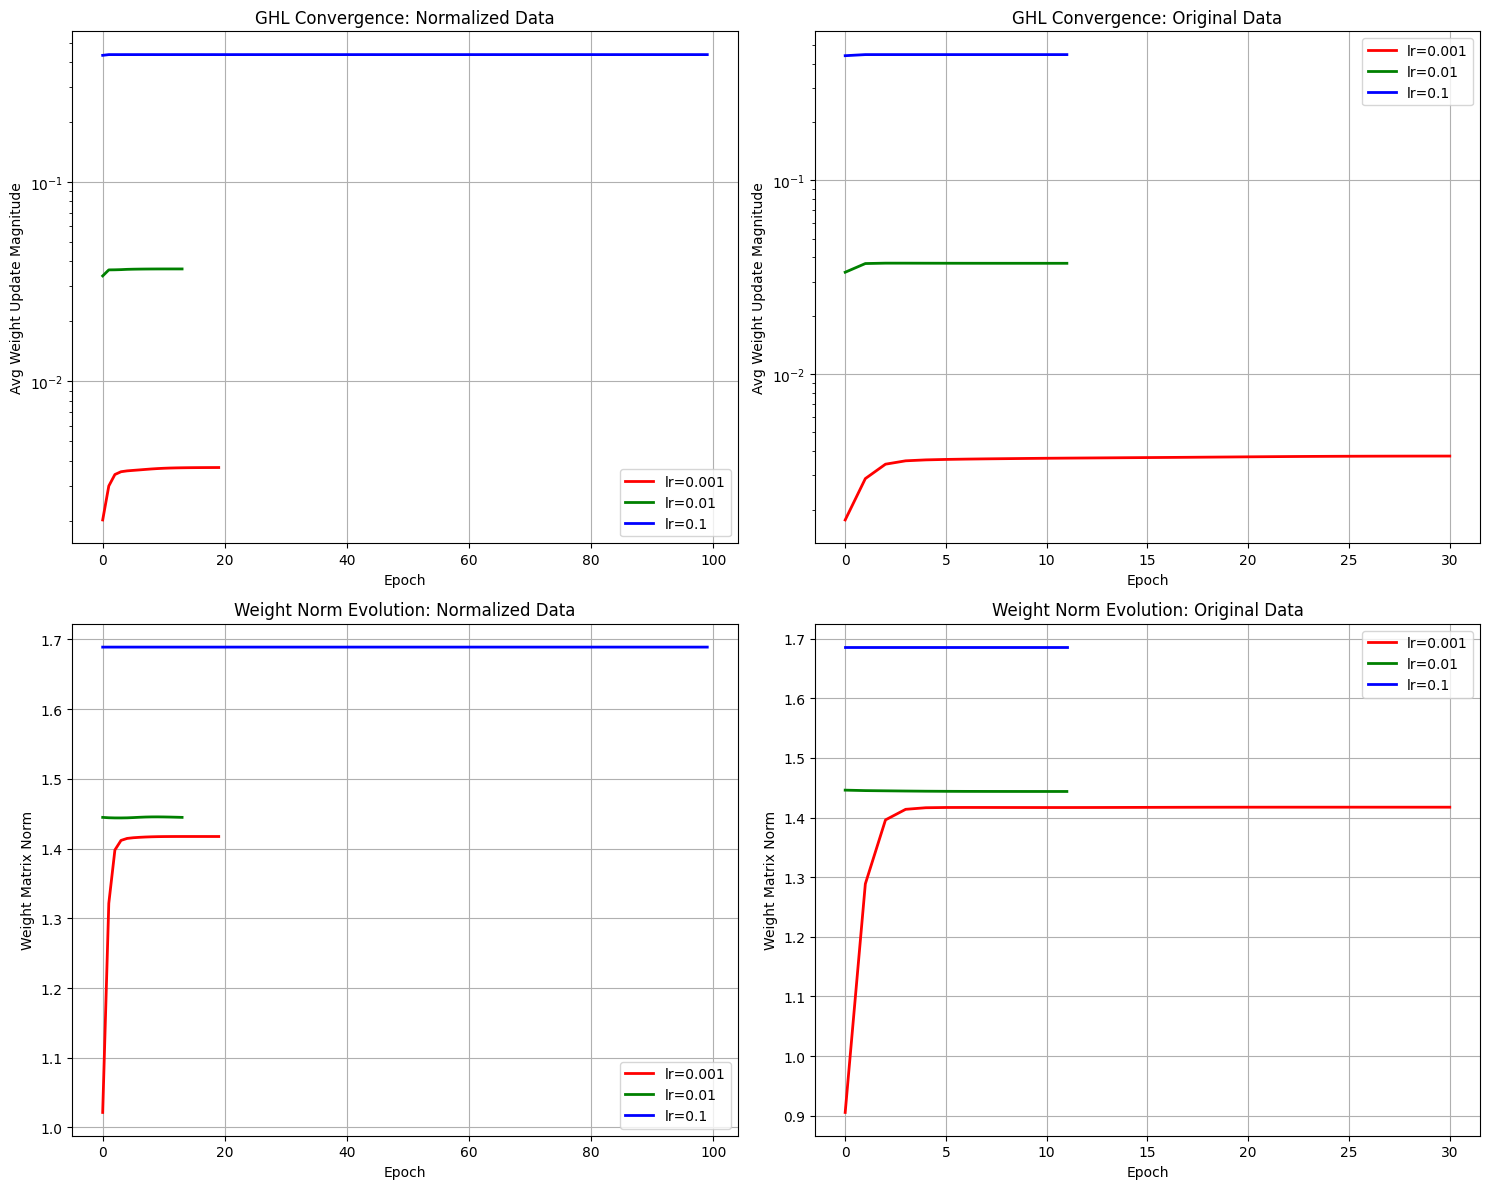

In [12]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Normalized Data Loss
ax1 = axes[0, 0]
for lr, color in zip(learning_rates, colors):
    ax1.plot(results_normalized[lr]['losses'], label=f"lr={lr}", color=color, linewidth=2)
ax1.set_title("GHL Convergence: Normalized Data")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Avg Weight Update Magnitude")
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

# Plot 2: Original Data Loss
ax2 = axes[0, 1]
for lr, color in zip(learning_rates, colors):
    ax2.plot(results_original[lr]['losses'], label=f"lr={lr}", color=color, linewidth=2)
ax2.set_title("GHL Convergence: Original Data")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Avg Weight Update Magnitude")
ax2.legend()
ax2.grid(True)
ax2.set_yscale('log')

# Plot 3: Normalized Data Weight Norms
ax3 = axes[1, 0]
for lr, color in zip(learning_rates, colors):
    ax3.plot(results_normalized[lr]['weight_norms'], label=f"lr={lr}", color=color, linewidth=2)
ax3.set_title("Weight Norm Evolution: Normalized Data")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Weight Matrix Norm")
ax3.legend()
ax3.grid(True)

# Plot 4: Original Data Weight Norms
ax4 = axes[1, 1]
for lr, color in zip(learning_rates, colors):
    ax4.plot(results_original[lr]['weight_norms'], label=f"lr={lr}", color=color, linewidth=2)
ax4.set_title("Weight Norm Evolution: Original Data")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Weight Matrix Norm")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

### **Questions:**

#### Which learning rate gives stable and fast convergence?

- Based on the experimental results, a learning rate of 0.001 offers the most stable and effective convergence among the tested values. Although higher learning rates like 0.01 and 0.1 lead to faster convergence in terms of epochs, they result in significantly higher final losses, indicating instability and poor convergence. Specifically, for both normalized and original data, the final loss with a learning rate of 0.001 was the lowest—0.003697 and 0.003775 respectively—demonstrating more accurate and stable learning.
- In contrast, a learning rate of 0.01 yielded a final loss over ten times higher, and 0.1 performed even worse with large losses and signs of overshooting. While 0.001 required slightly more epochs to converge, it consistently led to better results.
- Additionally, normalization further improved convergence behavior by reducing oscillations and enhancing gradient scaling, but even without it, the learning rate of 0.001 remained the most reliable. Therefore, considering both convergence quality and robustness, 0.001 is the optimal learning rate for achieving fast yet stable convergence.

#### How does normalization impact convergence speed?

- Normalization helps the model learn faster and more smoothly. It does this by making sure all input features are on the same scale — with a mean of 0 and a standard deviation of 1. This makes it easier for the model to update its weights properly during training.
- In the results, models trained on normalized data usually needed fewer or the same number of training steps (called epochs) to reach a good result. For example, with a learning rate of 0.001, the model trained on normalized data converged in 5 epochs, while the one with original data took 6 epochs. Normalized data also gave lower final losses, meaning the model made better predictions. It made learning more stable and reduced problems like jumping around or failing to learn when using higher learning rates. In short, normalization helps the model learn better and faster in most situations.